<a href="https://colab.research.google.com/github/annigue/annigue.github.io/blob/main/RL_Finanz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [278]:
#!pip install numpy pandas matplotlib gym gym-anytrading stable-baselines3 yfinance ta

In [279]:
#!pip install gymnasium



In [280]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from gymnasium import spaces
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO





[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


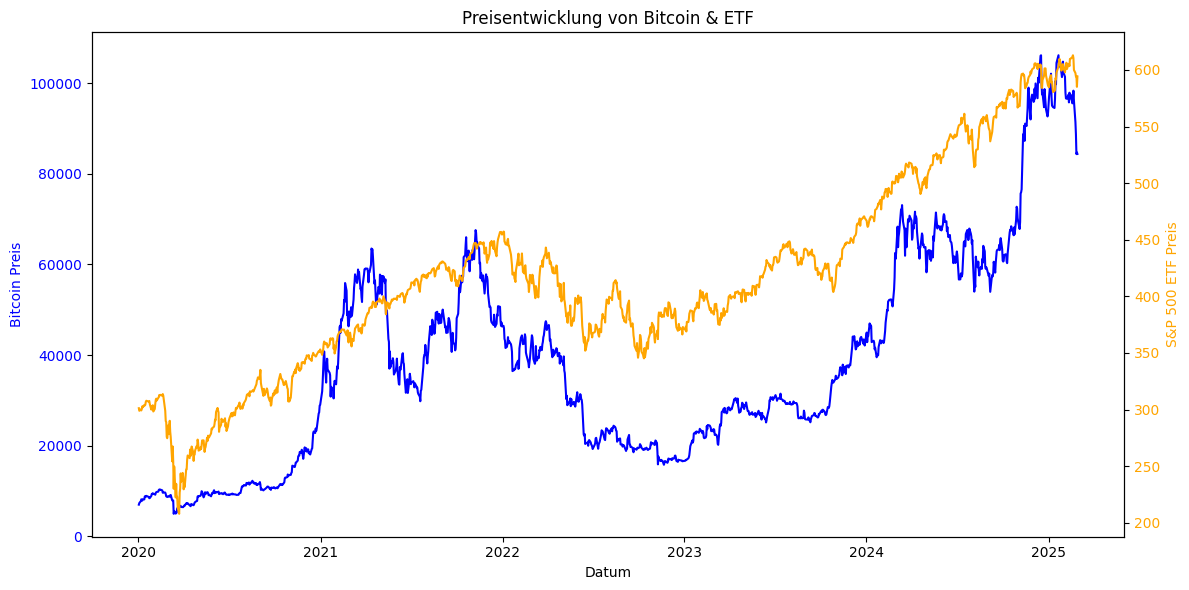

In [292]:
import yfinance as yf
import matplotlib.pyplot as plt

# Daten abrufen
btc_data = yf.download("BTC-USD", start="2020-01-01", end="2025-03-01")
spy_data = yf.download("SPY", start="2020-01-01", end="2025-03-01")

# Gemeinsame Datumswerte finden
common_dates = btc_data.index.intersection(spy_data.index)

# Extrahieren der Preise für die gemeinsamen Daten
bitcoin_prices = btc_data.loc[common_dates, 'Close']
spy_prices = spy_data.loc[common_dates, 'Close']

# Plot der Preisentwicklung
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bitcoin-Daten auf der ersten Y-Achse
ax1.plot(common_dates, bitcoin_prices, 'b-', label='Bitcoin')
ax1.set_xlabel('Datum')
ax1.set_ylabel('Bitcoin Preis', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Zweite Y-Achse für SPY-Daten
ax2 = ax1.twinx()
ax2.plot(common_dates, spy_prices, 'orange', label='S&P 500 ETF (SPY)')
ax2.set_ylabel('S&P 500 ETF Preis', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Preisentwicklung von Bitcoin & ETF')
fig.tight_layout()
plt.show()


In [282]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces

class PortfolioEnv(gym.Env):
    """Eine RL-Umgebung für Portfolio-Optimierung mit BTC & ETFs"""

    def __init__(self, btc_data, spy_data):
        super(PortfolioEnv, self).__init__()

        self.btc_prices = btc_data['Close'].values
        self.spy_prices = spy_data['Close'].values

        # Berechnung der täglichen Renditen sicherstellen
        btc_data['returns'] = btc_data['Close'].pct_change().fillna(0)
        spy_data['returns'] = spy_data['Close'].pct_change().fillna(0)

        # Startkapital
        self.initial_balance = 10000
        self.balance = round(float(self.initial_balance), 2)  # Sicherstellen, dass es ein einzelner Float ist
        self.shares_btc = 0
        self.shares_spy = 0
        self.current_step = 0

        # Action-Space (Kontinuierlicher Aktionsraum von -1 bis 1)
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)

        # Observation-Space (BTC-Preis, ETF-Preis, Kapitalstand)
        self.observation_space = spaces.Box(
            low=0, high=np.inf, shape=(3,), dtype=np.float32
        )

    def reset(self, seed=None, options=None):
        """Setzt die Umgebung auf den Anfangszustand zurück"""
        super().reset(seed=seed)  # Setzt die zufällige Seed, falls vorhanden
        self.balance = round(float(self.initial_balance), 2)  # Sicherstellen, dass es ein einzelner Float ist
        self.shares_btc = 0
        self.shares_spy = 0
        self.current_step = 0

        return self._get_obs(), {}  # `gymnasium` erwartet (obs, info)

    def step(self, action):
        """Führt eine Aktion aus: Kaufen, Verkaufen oder Halten"""
        action = float(action[0])  # PPO gibt eine Liste zurück, also extrahiere das erste Element
        max_step = min(len(self.btc_prices), len(self.spy_prices)) - 1
        current_btc_price = float(self.btc_prices[self.current_step])
        current_spy_price = float(self.spy_prices[self.current_step])

        # Berechne Investitionsbetrag (bis zu 20% des Kapitals, abhängig von `action`)
        invest_amount = round(abs(action) * 0.2 * self.balance, 2)

        if action > 0 and self.balance >= invest_amount:  # BTC kaufen
            self.shares_btc += invest_amount / current_btc_price
            self.balance = round(self.balance - invest_amount, 2)

        elif action < 0 and self.balance >= invest_amount:  # SPY kaufen
            self.shares_spy += invest_amount / current_spy_price
            self.balance = round(self.balance - invest_amount, 2)

        # Portfolio-Wert berechnen
        portfolio_value = round(
            float(self.balance) + (self.shares_btc * current_btc_price) + (self.shares_spy * current_spy_price), 2
        )

        # Reward = Portfolio-Wert maximieren
        reward = portfolio_value - self.initial_balance

        # Prüfen, ob wir am Ende des Datensatzes sind
        if self.current_step >= len(self.btc_prices) - 1:
            done = True
            self.current_step = len(self.btc_prices) - 1  # Verhindert den Fehler, indem wir den maximalen Index sichern
        else:
            done = False
            self.current_step += 1  # Erhöhe nur, wenn es noch Daten gibt

        truncated = False  # `gymnasium` benötigt dieses Flag

        return self._get_obs(), reward, done, truncated, {}

    def _get_obs(self):
        max_step = min(len(self.btc_prices), len(self.spy_prices)) - 1
        """Liefert die aktuelle Umgebung zurück (numerische Werte)"""
        max_step = min(len(self.btc_prices), len(self.spy_prices)) - 1
        if self.current_step > max_step:  # Sicherheitscheck
          self.current_step = max_step  # Setze auf den letzten gültigen Index

        return np.array([
            round(float(self.btc_prices[self.current_step]), 2),  # BTC-Preis
            round(float(self.spy_prices[self.current_step]), 2),  # SPY-Preis
            round(float(self.balance), 2)  # Kapitalstand
        ], dtype=np.float32)

    def render(self):
        """Optional: Visualisierung"""
        print(f"Step: {self.current_step}, Balance: {self.balance}, BTC: {self.shares_btc}, SPY: {self.shares_spy}")


In [283]:
env = PortfolioEnv(btc_data, spy_data)
check_env(env)  # Prüft, ob die Umgebung kompatibel mit RL-Algorithmen ist

# Beispielhafter Durchlauf mit zufälligen Aktionen
obs = env.reset()
for _ in range(10):
    action = env.action_space.sample()  # Zufällige Aktion wählen
    obs, reward, done, truncated, info = env.step(action)  # Jetzt 5 Werte entpacken
    env.render()  # Zeigt den aktuellen Status an
    if done:
        break


Step: 1, Balance: 8881.13, BTC: 0.15539484890672065, SPY: 0
Step: 2, Balance: 8628.94, BTC: 0.15539484890672065, SPY: 0.8436870472032204
Step: 3, Balance: 7408.24, BTC: 0.15539484890672065, SPY: 4.911947920217624
Step: 4, Balance: 6706.61, BTC: 0.15539484890672065, SPY: 7.256882731043056
Step: 5, Balance: 5806.88, BTC: 0.15539484890672065, SPY: 10.247951596734186
Step: 6, Balance: 5588.02, BTC: 0.15539484890672065, SPY: 10.970631075646693
Step: 7, Balance: 5123.88, BTC: 0.2122490244728139, SPY: 10.970631075646693
Step: 8, Balance: 4796.35, BTC: 0.2122490244728139, SPY: 12.047853421602937
Step: 9, Balance: 4535.93, BTC: 0.2453011432373068, SPY: 12.047853421602937
Step: 10, Balance: 4072.02, BTC: 0.30210723166617925, SPY: 12.047853421602937


<ipython-input-282-4bafdff08359>:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  round(float(self.btc_prices[self.current_step]), 2),  # BTC-Preis


In [284]:
#!pip install stable-baselines3[extra] gymnasium numpy
#!pip install 'shimmy>=2.0'

In [285]:
#!pip install stable_baselines3.common.envs

<ipython-input-259-4bafdff08359>:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  round(float(self.btc_prices[self.current_step]), 2),  # BTC-Preis


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1273 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------


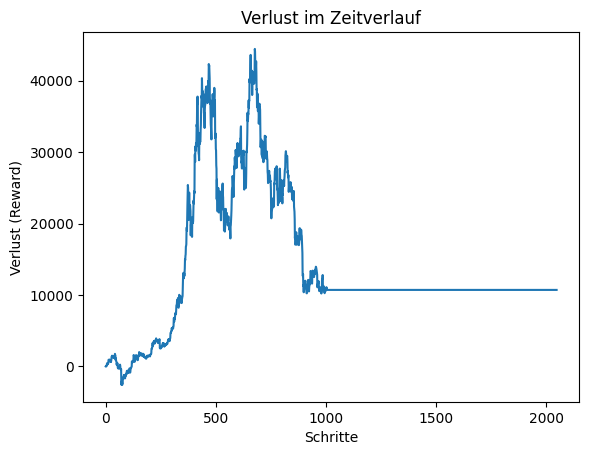

In [286]:
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

# Liste für den Verlust
losses = []

# Definiere eine Callback-Funktion, um den Verlust zu speichern
class LossCallback(BaseCallback):
    def __init__(self):
        super().__init__()

    def _on_step(self):
        # Speichern des aktuellen Verlusts
        # Anstatt `episode_reward`, speichern wir `reward` aus der `step`-Methode
        losses.append(self.locals['rewards'][0])  # Belohnung des aktuellen Schritts
        return True

# Erstelle das Modell
model = PPO("MlpPolicy", vec_env, verbose=1)

# Setze den Callback
loss_callback = LossCallback()

# Trainiere das Modell und sammle den Verlust
model.learn(total_timesteps=10, callback=loss_callback)

# Plot des Verlusts
plt.plot(losses)
plt.title("Verlust im Zeitverlauf")
plt.xlabel("Schritte")
plt.ylabel("Verlust (Reward)")
plt.show()


<ipython-input-259-4bafdff08359>:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  round(float(self.btc_prices[self.current_step]), 2),  # BTC-Preis


Step 1: Balance: 9997.5400390625, BTC: 6985.47021484375, SPY: 298.9100036621094
Step 2: Balance: 9993.98046875, BTC: 7344.8798828125, SPY: 300.04998779296875
Step 3: Balance: 9991.51953125, BTC: 7410.66015625, SPY: 299.2099914550781
Step 4: Balance: 9989.0595703125, BTC: 7411.31982421875, SPY: 300.80999755859375
Step 5: Balance: 9986.599609375, BTC: 7769.22021484375, SPY: 302.8500061035156
Step 6: Balance: 9984.1396484375, BTC: 8163.68994140625, SPY: 301.9700012207031
Step 7: Balance: 9981.6796875, BTC: 8079.85986328125, SPY: 304.04998779296875
Step 8: Balance: 9979.2197265625, BTC: 7879.06982421875, SPY: 303.5899963378906
Step 9: Balance: 9976.759765625, BTC: 8166.5498046875, SPY: 304.2699890136719
Step 10: Balance: 9974.2998046875, BTC: 8037.5400390625, SPY: 306.79998779296875


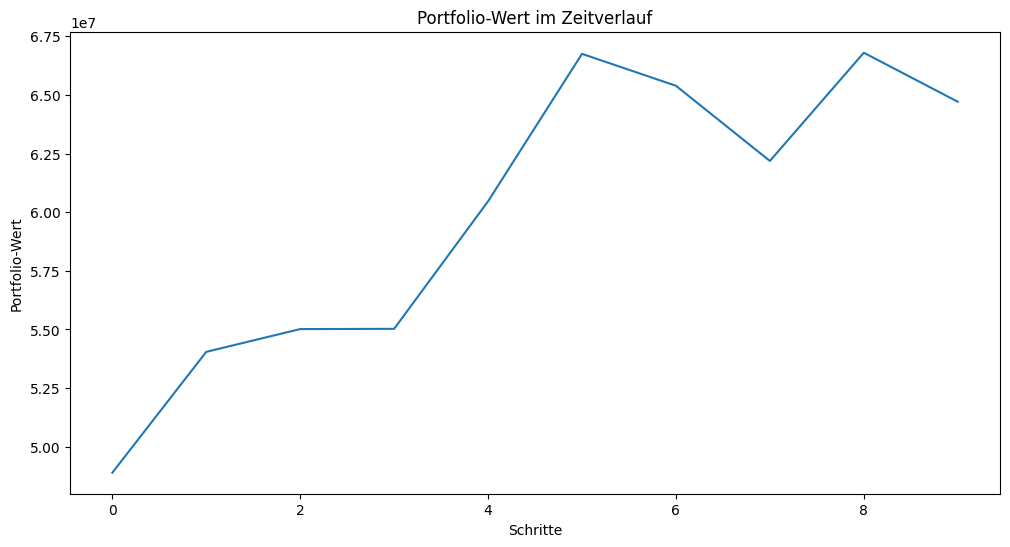

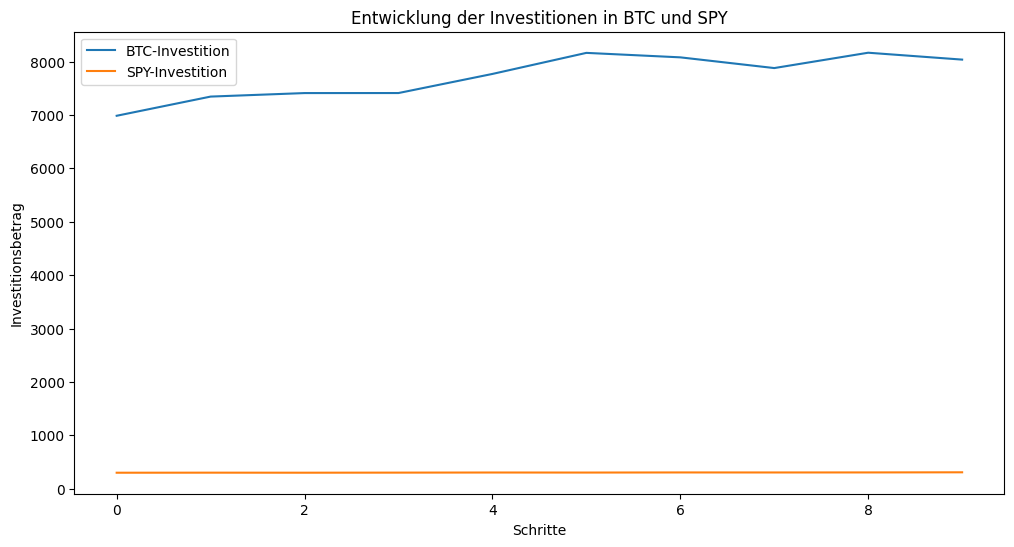

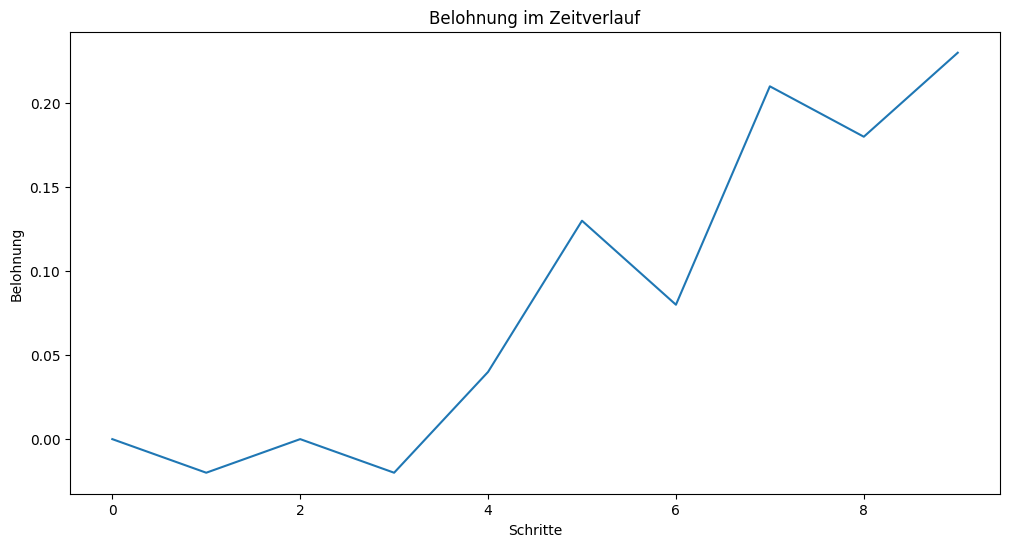

In [287]:
# --- TESTEN DES MODELLS --- #
obs = vec_env.reset()  # Setze die Umgebung zurück

portfolio_values = []  # Liste für Portfolio-Werte
btc_investments = []  # Liste für BTC-Investitionen
spy_investments = []  # Liste für SPY-Investitionen
rewards = []  # Liste für Belohnungen

for step in range(10):  # Beispiel: 10 Schritte testen
    action, _ = model.predict(obs, deterministic=True)  # Vorhersage der besten Aktion

    # Der Agent führt die Aktion aus
    obs, reward, done, info = vec_env.step(action)

    # Speichern der Daten für Visualisierungen
    btc_price = obs[0][0]  # BTC-Preis aus der Beobachtung
    spy_price = obs[0][1]  # SPY-Preis aus der Beobachtung
    portfolio_value = obs[0][2] + (btc_price * obs[0][0]) + (spy_price * obs[0][1])
    portfolio_values.append(portfolio_value)
    btc_investments.append(btc_price)
    spy_investments.append(spy_price)
    rewards.append(reward)

    # Zeige den Status der Umgebung an
    print(f"Step {step + 1}: Balance: {obs[0][2]}, BTC: {obs[0][0]}, SPY: {obs[0][1]}")

    if done:
        break

# --- VISUALISIERUNGEN --- #

# 1. Portfolio-Wert über die Zeit
plt.figure(figsize=(12,6))
plt.plot(portfolio_values)
plt.title("Portfolio-Wert im Zeitverlauf")
plt.xlabel("Schritte")
plt.ylabel("Portfolio-Wert")
plt.show()

# 2. Entwicklung von BTC- und SPY-Investitionen
plt.figure(figsize=(12,6))
plt.plot(btc_investments, label="BTC-Investition")
plt.plot(spy_investments, label="SPY-Investition")
plt.title("Entwicklung der Investitionen in BTC und SPY")
plt.xlabel("Schritte")
plt.ylabel("Investitionsbetrag")
plt.legend()
plt.show()

# 3. Reward über die Zeit
plt.figure(figsize=(12,6))
plt.plot(rewards)
plt.title("Belohnung im Zeitverlauf")
plt.xlabel("Schritte")
plt.ylabel("Belohnung")
plt.show()



In [288]:
#tensorboard --logdir=./ppo_tensorboard/

In [289]:
# Testen des Modells
obs = vec_env.reset()  # Gibt nur die Beobachtungen zurück (nicht `info`)

for step in range(10):  # Beispiel: 10 Schritte trainieren
    # Modellvorhersage für die aktuelle Beobachtung
    action, _states = model.predict(obs, deterministic=True)  # Nutze `obs` (Beobachtung) und `deterministic=True` für beständige Aktionen

    # Schritt im VecEnv
    obs, reward, done, info = vec_env.step(action)  # Ein Schritt im `VecEnv`

    # Zeige den Status der Umgebung an
    vec_env.render()  # Zeigt den Status der Umgebung an (Visualisierung der Umgebungen)

    # Zeige explizit den Status der ersten Umgebung an
    print(f"Step {step + 1}: Balance: {obs[0][2]}, BTC: {obs[0][0]}, SPY: {obs[0][1]}")  # Beispiel: Zeige die Balance, BTC und SPY an

    # Wenn das Ende der Episode erreicht ist, setze die Umgebung zurück
    if done[0]:  # Achte darauf, dass du `done` für jede Umgebung überprüfst
        print(f"Episode {step + 1} abgeschlossen. Rücksetzen der Umgebung.")
        obs = vec_env.reset()  # Rücksetzen der Umgebung


Step 1: Balance: 9997.5400390625, BTC: 6985.47021484375, SPY: 298.9100036621094
Step 2: Balance: 9993.98046875, BTC: 7344.8798828125, SPY: 300.04998779296875
Step 3: Balance: 9991.51953125, BTC: 7410.66015625, SPY: 299.2099914550781
Step 4: Balance: 9989.0595703125, BTC: 7411.31982421875, SPY: 300.80999755859375
Step 5: Balance: 9986.599609375, BTC: 7769.22021484375, SPY: 302.8500061035156
Step 6: Balance: 9984.1396484375, BTC: 8163.68994140625, SPY: 301.9700012207031
Step 7: Balance: 9981.6796875, BTC: 8079.85986328125, SPY: 304.04998779296875
Step 8: Balance: 9979.2197265625, BTC: 7879.06982421875, SPY: 303.5899963378906
Step 9: Balance: 9976.759765625, BTC: 8166.5498046875, SPY: 304.2699890136719
Step 10: Balance: 9974.2998046875, BTC: 8037.5400390625, SPY: 306.79998779296875


<ipython-input-259-4bafdff08359>:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  round(float(self.btc_prices[self.current_step]), 2),  # BTC-Preis
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/base_vec_env.py:244: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")
